# Init

#### Imports

In [19]:
import utilities.logging as Logger
import integration.files as Files
import evaluation.general as GenEval
import evaluation.iv as IVEval
import utilities.macros as Macros
import plotting.plot as Plot
import utilities.constants as Constants
import os

#### Init

In [20]:
bib = Files.DataCollection()

Logger.setup(bib)
Logger.set_level(Logger.INFO)
Files.setup(bib, "Test", rf"/home/{os.getlogin()}/Downloads")
# Files.setup(bib, "Test", rf"C:\Users\capal\Downloads\PP")
GenEval.setup(bib)
IVEval.setup(bib)

(...) Logger.setup()
(...) Logger.set_level(lvl=Level.INFO)
(...) Files.setup(name=Test, root_dir=/home/dacap/Downloads)
(Test) GenEval.setup()
(Test) IVEval.setup()


#### Config

In [21]:
bib.data.file_name = "2023-11-04_G0_antenna.hdf5"
bib.params.volt_amp = (10000.0, 1000.0)
bib.params.evalTemperature = False
bib.params.linearizeYAxis = True
bib.params.normalizeXAxis = True
bib.params.smoothData = False
bib.iv_params.bins = 1200

#### Selection

In [22]:
GenEval.loadMeasurements(bib)
GenEval.showLoadedMeasurements(bib)
GenEval.select_measurement(bib, 1)

IVEval.select_edge(bib, 1, "up")

(Test) GenEval.loadMeasurements()
(Test)   Measurement header format unknown: critical field - list index out of range
(Test)   Measurement header format unknown: frequency_at_-20dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_-25dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_19.3GHz - list index out of range
(Test)   Measurement header format unknown: frequency_at_7.8GHz - list index out of range
(Test) GenEval.showLoadedMeasurements()
(Test)   [1] var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) GenEval.select_measurement(index=1)
(Test)   Selected: var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test)       with: 32 entries
(Test) IVEval.select_edge(num=1,dir=up)


In [23]:
Macros.load(bib, 1)
Macros.eval(bib, "adwin")

(Test) GenEval.select_CurveSet(var_range_index=1)
(Test)   Selected DataSet: nu=-30.0dBm
(Test) IVEval.loadCurveSet()
(Test)   Loading dataset: nu=-30.0dBm from var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) IVEval.filter_curve_sets(bin_count=1200)
(Test) IVEval.eval_loaded_curve_set()
(Test) IVEval.get_noise(adwin, ('time', 'current'), It)


## Calculation

In [24]:
Macros.bulk_eval(bib)

(Test)   Evaluating Set: 32/32 (97%) (id: nu=-1.0dBm)  (Test) 
Finished evaluating all sets
(Test)   Linearizing Y-axis values from dBm to V


# Exp

## Plot imports

In [25]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from plotting.corporate_design_colors_v4 import cmap

## Plots

(1200, 1200)


/tmp/ipykernel_9144/24945286.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


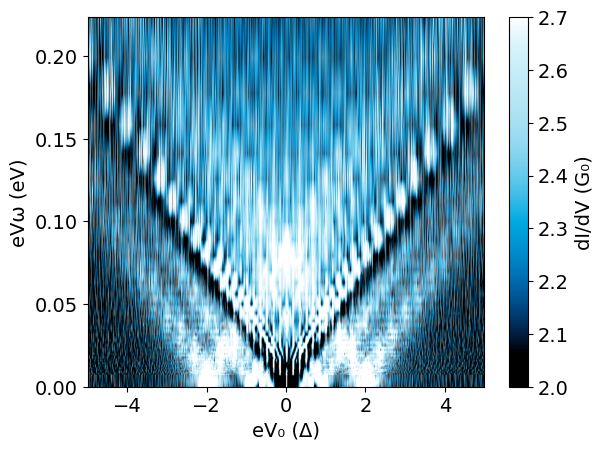

In [26]:
from plotting.plot import StyleKeys as SK

VVI_style = {
    SK.X_LABEL: "eV₀ (Δ)",
    SK.Y_LABEL: "eVω (eV)",
    SK.Z_LABEL: "dI/dV (G₀)",
    SK.SCALE: (1, 1, 1),
    SK.X_LIM: (-5, 5),
    # SK.Y_LIM: (0, 0.2),
    SK.CMAP: "seeblau",
    SK.CBAR: True,
    # SK.X_TICKS: (-5, 5, 2.5),
    SK.Y_TICKS: (0, 0.2, 0.05),
    SK.ASPECT: "auto",
    # SK.INTERPOL: "bilinear",
    SK.FLIP_VERTICAL: True,
}

fig, ax = plt.subplots()

Plot.map(bib, ["dVXC"], [VVI_style], fig, ax)


# plt.plot([-5, -2], [0.125, 0], color="orange", linewidth=2, linestyle="--")
# plt.plot([-2, 5], [0, 0.25], color="orange", linewidth=2, linestyle=":")

# plt.plot([-5, 2], [0.25, 0], color="orange", linewidth=2, linestyle="--")
# plt.plot([2, 5], [0, 0.125], color="orange", linewidth=2, linestyle=":")

# plt.plot([-5, 0], [0.2, 0], color="green", linewidth=2, linestyle="--")
# plt.plot([0, 5], [0, 0.2], color="green", linewidth=2, linestyle=":")

# plt.plot([-5, -1], [0.15, 0], color="red", linewidth=2, linestyle="--")
# plt.plot([1, 5], [0, 0.15], color="red", linewidth=2, linestyle=":")

# plt.ylim(0, 0.22)
fig.show()

(1200, 1200)


/tmp/ipykernel_9144/972421700.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


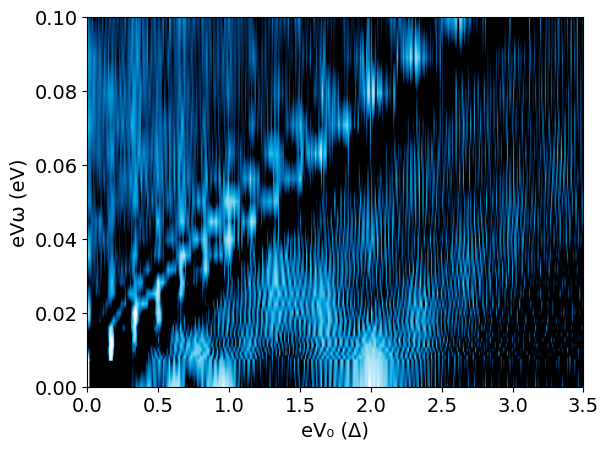

In [27]:
from plotting.plot import StyleKeys as SK

VVI_style = {
    SK.X_LABEL: "eV₀ (Δ)",
    SK.Y_LABEL: "eVω (eV)",
    SK.Z_LABEL: "dI/dV (G₀)",
    SK.SCALE: (1, 1, 1),
    SK.X_LIM: (0, 3.5),
    SK.Y_LIM: (0, 0.1),
    SK.CMAP: "seeblau",
    SK.CBAR: False,
    SK.C_LIM: (2, 5),
    # SK.X_TICKS: (-5, 5, 2.5),
    # SK.Y_TICKS: (0, 0.2, 0.05),
    SK.ASPECT: "auto",
    # SK.INTERPOL: "bilinear",
    SK.FLIP_VERTICAL: True,
}

fig, ax = plt.subplots()

Plot.map(bib, ["dVXC"], [VVI_style], fig, ax)

exp_fig_raw = ax.get_images()[0]

fig.show()

# Carlos

(251, 2399)


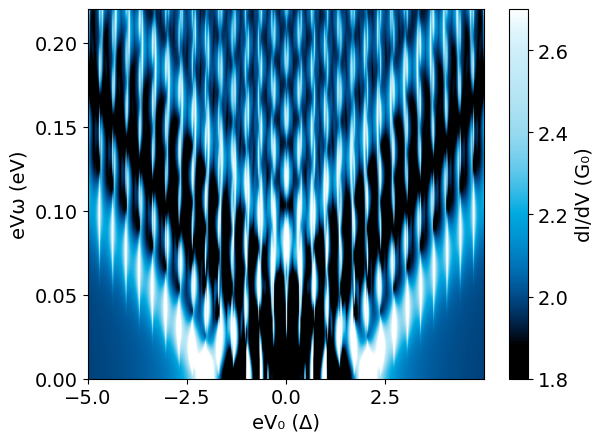

In [28]:
# Carlos SIM Map

# open jld2 file
file = "/home/dacap/Documents/p5control-bluefors-evaluation/simulation/data/TG-IV-Carlos.jld2"
# file = r"A:\Documents\Git\p5control-bluefors-evaluation\simulation\data\TG-IV-Carlos.jld2"


ts = [0.80, 0.62, 0.33, 0.25, 0.01]

# map = np.zeros((251, 589), dtype=np.float64)
map_Carlos = np.zeros((251, 2399), dtype=np.float64)
x = None
y = None
for t in ts:
    with h5py.File(file, "r") as f:
        dir = f["τ=" + str(t)]
        data = np.array(dir["dIdV"])
        map_Carlos += data

map_Carlos = np.flipud(map_Carlos)
x = np.linspace(-6.1, 6.1, map_Carlos.shape[1])
y = np.linspace(0, 0.26, map_Carlos.shape[0])  # np.linspace(0, 1, map.shape[0])

print(map_Carlos.shape)

map_Carlos = map_Carlos * 2 / 5

plt.imshow(
    map_Carlos,
    aspect="auto",
    extent=(x[0], x[-1], y[0], y[-1]),
    cmap=cmap(clim=(-0.1, 1.0)),
    clim=(1.8, 2.7),
)
cbar = plt.colorbar(label="dI/dV (G₀)")
cbar.ax.tick_params(labelsize=14)
cbar.set_label("dI/dV (G₀)", fontsize=14)
plt.xlim(-5, 5)
plt.ylim(0, 0.22)
plt.xlabel("eV₀ (Δ)", fontsize=14)
plt.ylabel("eVω (eV)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(np.arange(-5, 5, 2.5))
plt.yticks(np.arange(0, 0.215, 0.05))

plt.show()

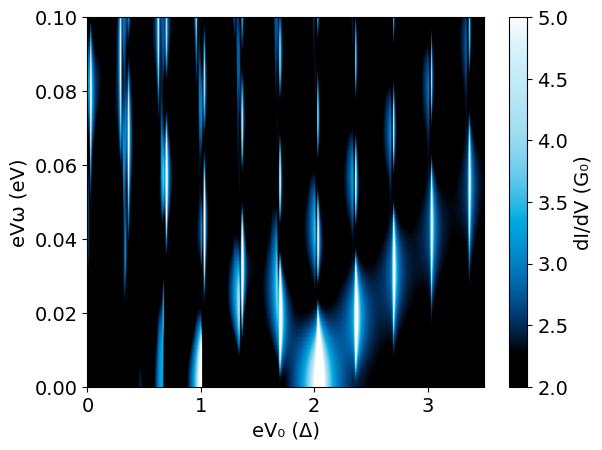

In [29]:
plt.imshow(
    map_Carlos,
    aspect="auto",
    extent=(x[0], x[-1], y[0], y[-1]),
    cmap=cmap(clim=(-0.1, 1.0)),
    clim=(2, 5),
)
cbar = plt.colorbar()
cbar.set_label("dI/dV (G₀)", fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.xlim(0, 3.5)
plt.ylim(0, 0.1)
plt.xlabel("eV₀ (Δ)", fontsize=14)
plt.ylabel("eVω (eV)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)

plt.show()

# Dynes

In [30]:
# Dynes SIM Map

import numpy as np
import h5py
import matplotlib.pyplot as plt
from plotting.corporate_design_colors_v4 import cmap

# open jld2 file
file = "/home/dacap/Documents/p5control-bluefors-evaluation/simulation/data/TG-IV.jld2"
# file = (
# r"A:\Documents\Git\p5control-bluefors-evaluation\simulation\data\TG-IV-David.jld2"
# )


ts = [0.80, 0.62, 0.33, 0.25, 0.01]

map_David = np.zeros((251, 1198), dtype=np.float64)
# map = np.zeros((251, 2399), dtype=np.float64)
# map = np.zeros((251,589), dtype=np.float64)
x = None
y = None
for t in ts:
    with h5py.File(file, "r") as f:
        dir = f["τ=" + str(t)]
        data = np.array(dir["dIdV"])
        map_David += data

map_David = np.flipud(map_David)
x = np.linspace(-5.99, 5.99, map_David.shape[1])
y = np.linspace(0, 0.26, map_David.shape[0])  # np.linspace(0, 1, map.shape[0])

print(map_David.shape)

# map_David = map_David * 1.2

plt.imshow(
    map_David,
    aspect="auto",
    extent=(x[0], x[-1], y[0], y[-1]),
    cmap=cmap(clim=(-0.1, 1.0)),
    clim=(2, 2.7),
)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label("dI/dV (G₀)", fontsize=14)
plt.xlim(-5, 5)
plt.ylim(0, 0.23)
plt.xlabel("eV₀ (Δ)", fontsize=14)
plt.ylabel("eVω (eV)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(np.arange(-5, 7, 2.5))
plt.yticks(np.arange(0, 0.215, 0.05))

plt.show()

ValueError: operands could not be broadcast together with shapes (251,1198) (251,1179) (251,1198) 

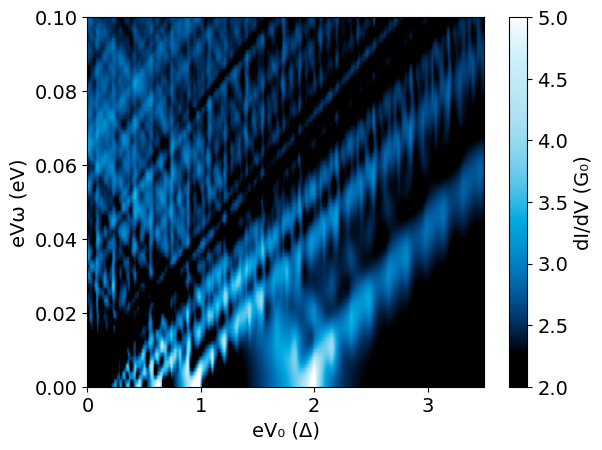

In [ ]:
plt.imshow(
    map_David,
    aspect="auto",
    extent=(x[0], x[-1], y[0], y[-1]),
    cmap=cmap(clim=(-0.1, 1.0)),
    clim=(2, 5),
)
cbar = plt.colorbar(label="dI/dV (G₀)")
cbar.set_label("dI/dV (G₀)", fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.xlim(0, 3.5)
plt.ylim(0, 0.1)
plt.xlabel("eV₀ (Δ)", fontsize=14)
plt.ylabel("eVω (eV)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)

plt.show()

# Zoom Compare

(Test) GenEval.loadMeasurements()
(Test)   Measurement header format unknown: critical field - list index out of range
(Test)   Measurement header format unknown: frequency_at_-20dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_-25dBm - list index out of range
(Test)   Measurement header format unknown: frequency_at_19.3GHz - list index out of range
(Test)   Measurement header format unknown: frequency_at_7.8GHz - list index out of range
(Test) GenEval.showLoadedMeasurements()
(Test)   [1] var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) GenEval.select_measurement(index=1)
(Test)   Selected: var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test)       with: 32 entries
(Test) IVEval.select_edge(num=1,dir=up)
(Test) GenEval.select_CurveSet(var_range_index=1)
(Test)   Selected DataSet: nu=-30.0dBm
(Test) IVEval.loadCurveSet()
(Test)   Loading dataset: nu=-30.0dBm from var=(vna_amplitudes,(-

(Test)   Evaluating Set: 32/32 (97%) (id: nu=-1.0dBm)(Test) 
Finished evaluating all sets
(Test)   Linearizing Y-axis values from dBm to V
(Test)   Smoothing data with moving average
(1200, 1191)


C:\Users\capal\AppData\Local\Temp\ipykernel_10332\3945631331.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


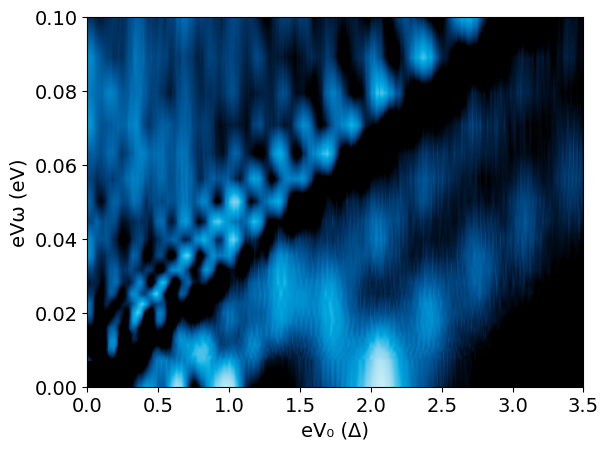

In [ ]:
bib.params.smoothData = True
GenEval.loadMeasurements(bib)
GenEval.showLoadedMeasurements(bib)
GenEval.select_measurement(bib, 1)

IVEval.select_edge(bib, 1, "up")
Macros.load(bib, 1)
Macros.eval(bib, "adwin")
Macros.bulk_eval(bib)
from plotting.plot import StyleKeys as SK

VVI_style = {
    SK.X_LABEL: "eV₀ (Δ)",
    SK.Y_LABEL: "eVω (eV)",
    SK.Z_LABEL: "dI/dV (G₀)",
    SK.SCALE: (1, 1, 1),
    SK.X_LIM: (0, 3.5),
    SK.Y_LIM: (0, 0.1),
    SK.CMAP: "seeblau",
    SK.CBAR: False,
    SK.C_LIM: (2, 5),
    # SK.X_TICKS: (-5, 5, 2.5),
    # SK.Y_TICKS: (0, 0.2, 0.05),
    SK.ASPECT: "auto",
    # SK.INTERPOL: "bilinear",
    SK.FLIP_VERTICAL: True,
}

fig, ax = plt.subplots()

Plot.map(bib, ["dVXC"], [VVI_style], fig, ax)

exp_fig_smooth = ax.get_images()[0]

fig.show()

C:\Users\capal\AppData\Local\Temp\ipykernel_10332\3231049830.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


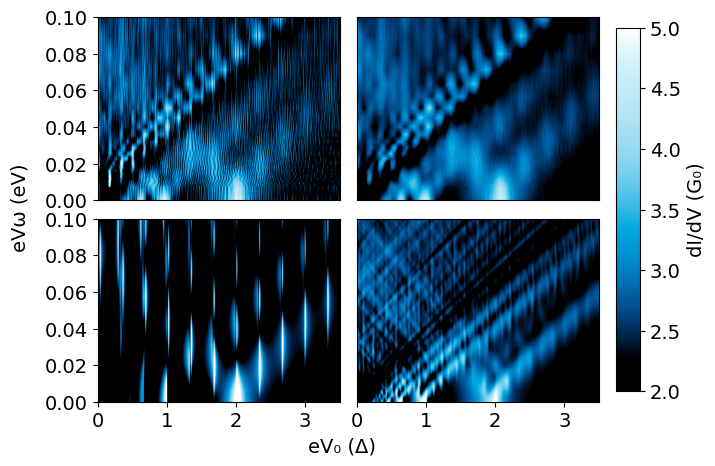

In [ ]:
from matplotlib.gridspec import GridSpec

clim_param = (2, 5)
xlim_param = (0, 3.5)
xticks = np.arange(0, 3 + 1, 1)
ylim_param = (0, 0.1)
yticks = np.arange(0, 0.1 + 0.02, 0.02)

# figure with 4 subplots in a 2x2 grid
# fig, axs = plt.subplots(2, 2, figsize=(6, 5), sharex=True, sharey=True)
fig = plt.figure(figsize=(7, 5))
gs = GridSpec(2, 3, width_ratios=[1, 1, 0.1], wspace=0.1, hspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
cax = fig.add_subplot(gs[:, 2])

ax1.imshow(
    exp_fig_raw.get_array(),
    aspect="auto",
    extent=exp_fig_raw.get_extent(),
    cmap=exp_fig_raw.get_cmap(),
    clim=exp_fig_raw.get_clim(),
)
ax1.tick_params(axis="both", which="major", labelsize=14)
ax1.set_xlim(*xlim_param)
ax1.set_ylim(*ylim_param)
ax1.set_xticks([])
ax1.set_yticks(yticks)

ax2.imshow(
    exp_fig_smooth.get_array(),
    aspect="auto",
    extent=exp_fig_smooth.get_extent(),
    cmap=exp_fig_smooth.get_cmap(),
    clim=exp_fig_smooth.get_clim(),
)
ax2.set_xlim(*xlim_param)
ax2.set_ylim(*ylim_param)
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(
    map_Carlos,
    aspect="auto",
    extent=(x[0], x[-1], y[0], y[-1]),
    cmap=cmap(clim=(-0.1, 1.0)),
    clim=clim_param,
)
ax3.set_xlim(*xlim_param)
ax3.set_xticks(xticks)
ax3.set_ylim(*ylim_param)
ax3.set_yticks(yticks)
ax3.tick_params(axis="both", which="major", labelsize=14)

ax4.imshow(
    map_David,
    aspect="auto",
    extent=(x[0], x[-1], y[0], y[-1]),
    cmap=cmap(clim=(-0.1, 1.0)),
    clim=clim_param,
)
ax4.set_xlim(*xlim_param)
ax4.set_xticks(xticks)
ax4.set_ylim(*ylim_param)
ax4.set_yticks([])
ax4.tick_params(axis="both", which="major", labelsize=14)

cax.set_xticks([])
cax.set_yticks([])
# cax.set_frame_on(False)
cax.set_aspect(5)

cbar = fig.colorbar(ax4.images[0], cax=cax, orientation="vertical")
cbar.set_label("dI/dV (G₀)", fontsize=14)
cbar.ax.tick_params(labelsize=14)

fig.text(0.475, 0.01, "eV₀ (Δ)", ha="center", fontsize=14)
fig.text(0, 0.5, "eVω (eV)", va="center", rotation="vertical", fontsize=14)

fig.show()

# Individuals

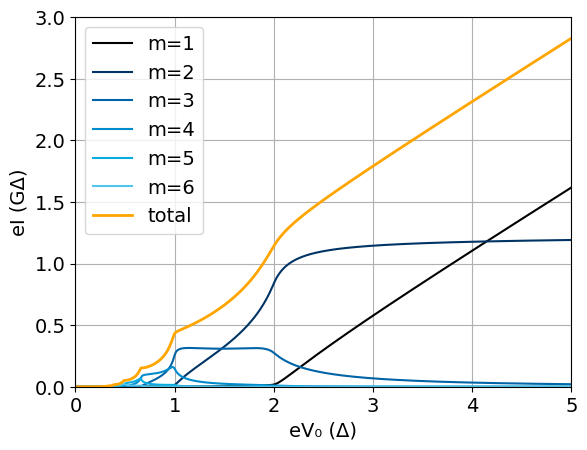

In [ ]:
file = r"A:\Documents\Git\p5control-bluefors-evaluation\simulation\data\Reference\Individuals-fixed.hdf5"

curves = dict()

with h5py.File(file, "r") as f:
    for key, value in f.items():
        x = np.copy(value["V0"])
        ys = np.copy(value["Im"])
        curves[key] = (x, ys)

tau = [0.5]

for t in tau:
    x, ys = curves[str(t)]
    y = np.zeros_like(x)
    for i, yi in enumerate(ys):
        y += yi
        if i < 6:
            plt.plot(x, yi, label=f"m={i+1}", color=cmap(clim=(0, 1))(i / 10))
    plt.plot(x, y, label=f"total", color="orange", linewidth=2)
plt.grid()
plt.legend(fontsize=14)
plt.xlim(0, 5)
plt.ylim(0, 3)
# plt.xlim(0,0.5)
# plt.ylim(0,0.0001)
plt.xlabel("eV₀ (Δ)", fontsize=14)
plt.ylabel("eI (GΔ)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)

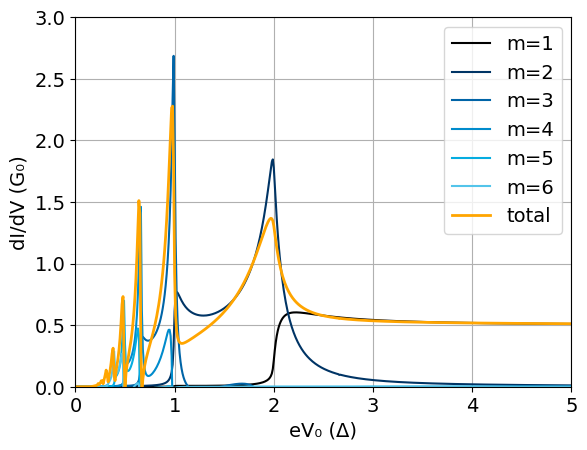

In [ ]:
for t in tau:
    x, ys = curves[str(t)]
    y = np.zeros_like(x)
    for i, yi in enumerate(ys):
        y += yi
        if i < 6:
            plt.plot(
                x[:-1],
                np.diff(yi) / np.diff(x),
                label=f"m={i+1}",
                color=cmap(clim=(0, 1))(i / 10),
            )
    plt.plot(
        x[:-1], np.diff(y) / np.diff(x), label=f"total", color="orange", linewidth=2
    )

plt.grid()
plt.legend(fontsize=14)
plt.xlim(0, 5)
plt.ylim(0, 3)
plt.xlabel("eV₀ (Δ)", fontsize=14)
plt.ylabel("dI/dV (G₀)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)

(Test) GenEval.select_CurveSet(var_range_index=1)
(Test)   Selected DataSet: nu=-30.0dBm
(Test) IVEval.loadCurveSet()
(Test)   Loading dataset: nu=-30.0dBm from var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) IVEval.filter_curve_sets(bin_count=1200)
(Test) IVEval.eval_loaded_curve_set()
(Test) IVEval.get_noise(adwin, ('time', 'current'), It)


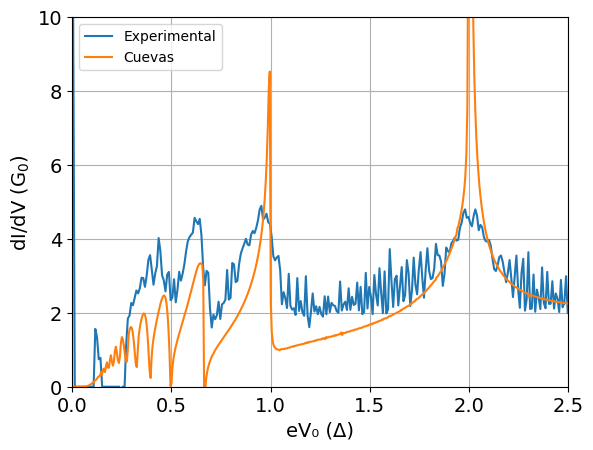

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from utilities.math import moving_average

evolution = 0

# plt.figure(figsize=(5, 5))

Macros.load(bib, 1)
Macros.eval(bib, "adwin")
x_exp = (
    bib.result.maps["dVXC"].x_axis.values
    if not bib.params.smoothData
    else bib.result.maps["dVXC"].x_axis.values[:-9]
)
y_exp = bib.result.maps["dVXC"].values[evolution, :]
x_theo_curve_carlos = np.linspace(-6, 6, map_Carlos.shape[1])
y_theo_curve_carlos = np.flipud(map_Carlos)[evolution, :]
x_theo_curve_david = np.linspace(-5.99, 5.99, map_David.shape[1])
y_theo_curve_david = np.flipud(map_David)[evolution, :]

plt.plot(x_exp, y_exp, label="Experimental")
plt.plot(x_theo_curve_carlos, y_theo_curve_carlos, label="Cuevas")
# plt.plot(x_theo_curve_david, y_theo_curve_david, label="PAMAR")


plt.xlabel("eV₀ (Δ)", fontsize=14)
plt.ylabel("dI/dV (G$_0$)", fontsize=14)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xlim(0, 2.5)
plt.ylim(0, 10)
plt.legend()
plt.grid()

# Exp

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import utilities.math as Math
from scipy import constants

In [ ]:
IVEval.select_edge(bib, -1, "up")
Macros.load(bib, 1)
Macros.eval(bib, "adwin")

(Test) IVEval.select_edge(num=-1,dir=up)
(Test)   Edge number -1 selected. This will not filter the data.
(Test) GenEval.select_CurveSet(var_range_index=1)
(Test)   Selected DataSet: nu=-30.0dBm
(Test) IVEval.loadCurveSet()
(Test)   Loading dataset: nu=-30.0dBm from var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) IVEval.filter_curve_sets(bin_count=1200)
(Test) IVEval.eval_loaded_curve_set()
(Test) IVEval.get_noise(adwin, ('time', 'current'), It)


[]

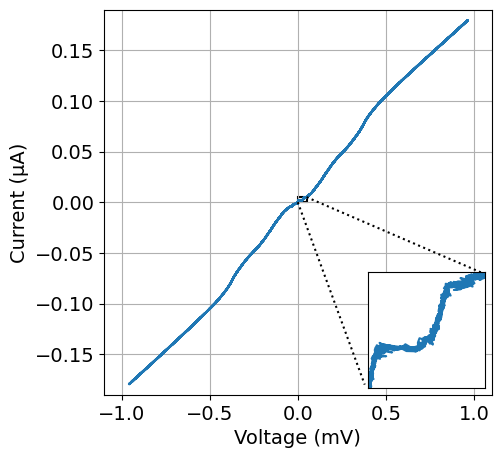

In [ ]:
x = bib.evaluation.raw_sets["adwin"].curves["voltage"]
y = bib.evaluation.raw_sets["adwin"].curves["current"]
x = x[15:-15]
y = y[15:-15]

x = x * 1e3
y = y * 1e6

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x, y)

# inset
inset_pos = ((0, 0), (0.05, 0.005))

ax.add_patch(
    mpatches.Rectangle(
        (inset_pos[0][0], inset_pos[0][1]),
        inset_pos[1][0],
        inset_pos[1][1],
        fill=False,
        color="black",
        linewidth=1.5,
    )
)
# ax.plot([1.05, 2.05], [2, 0], color="black", linewidth=1.5, linestyle=":")
# ax.plot([2, 5.3], [5, 1.5], color="black", linewidth=1.5, linestyle=":")
ax.plot(
    [0, 0.38],
    [0, -0.18],
    color="black",
    linewidth=1.5,
    linestyle=":",
)
ax.plot(
    [0.05, 1.05],
    [0.005, -0.07],
    color="black",
    linewidth=1.5,
    linestyle=":",
)


ax.set_xlabel("Voltage (mV)", fontsize=14)
ax.set_ylabel("Current (µA)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-0.19, 0.19)
ax.grid()

# =================================================

ax_inset = inset_axes(
    ax,
    width="30%",
    height="30%",
    loc="lower right",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
)
ax_inset.plot(x, y)
ax_inset.set_xlim(inset_pos[0][0], inset_pos[1][0])
ax_inset.set_ylim(inset_pos[0][1], inset_pos[1][1])
ax_inset.tick_params(labelleft=False, labelbottom=False)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

[]

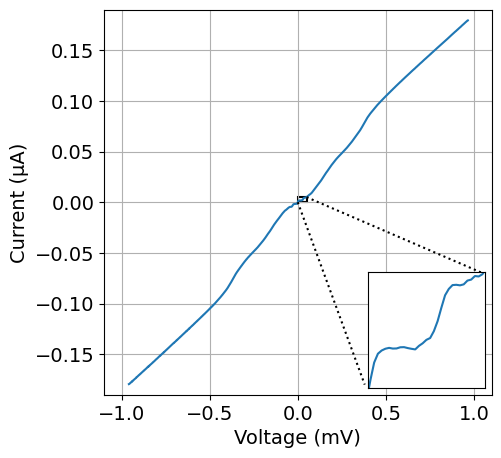

In [ ]:
x = bib.evaluation.filtered_sets["adwin"].curves["voltage-bin"]
y = bib.evaluation.filtered_sets["adwin"].curves["current-voltage"]
# x = x[15:-15]
# y = y[15:-15]

x = x * 1e3
y = y * 1e6

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x, y)

# inset
inset_pos = ((0, 0), (0.05, 0.005))

ax.add_patch(
    mpatches.Rectangle(
        (inset_pos[0][0], inset_pos[0][1]),
        inset_pos[1][0],
        inset_pos[1][1],
        fill=False,
        color="black",
        linewidth=1.5,
    )
)
ax.plot(
    [0, 0.38],
    [0, -0.18],
    color="black",
    linewidth=1.5,
    linestyle=":",
)
ax.plot(
    [0.05, 1.05],
    [0.005, -0.07],
    color="black",
    linewidth=1.5,
    linestyle=":",
)


ax.set_xlabel("Voltage (mV)", fontsize=14)
ax.set_ylabel("Current (µA)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-0.19, 0.19)
ax.grid()

# =================================================

ax_inset = inset_axes(
    ax,
    width="30%",
    height="30%",
    loc="lower right",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
)
ax_inset.plot(x, y)
ax_inset.set_xlim(inset_pos[0][0], inset_pos[1][0])
ax_inset.set_ylim(inset_pos[0][1], inset_pos[1][1])
ax_inset.tick_params(labelleft=False, labelbottom=False)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

[]

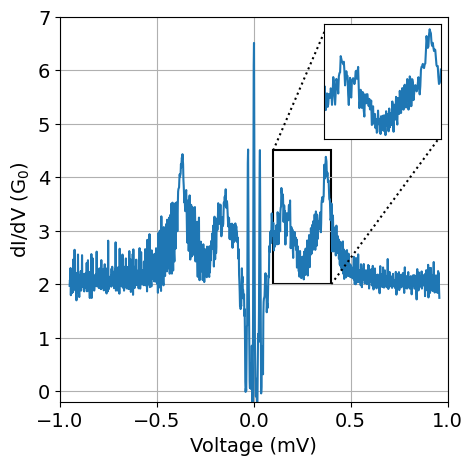

In [ ]:
x = bib.evaluation.cached_sets["adwin"].curves["voltage-bin"]
y = bib.evaluation.cached_sets["diffs"].curves["diff_conductance"]

x = x[5:-5]
y = y[5:-5]

x = x * 1e3
# y = y*1E6

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x, y)

# inset
ax.add_patch(
    mpatches.Rectangle((0.1, 2), 0.3, 2.5, fill=False, color="black", linewidth=1.5)
)
ax.plot(
    [0.1, 0.38],
    [4.5, 6.85],
    color="black",
    linewidth=1.5,
    linestyle=":",
)
ax.plot(
    [0.4, 0.95],
    [2, 4.7],
    color="black",
    linewidth=1.5,
    linestyle=":",
)


ax.set_xlabel("Voltage (mV)", fontsize=14)
ax.set_ylabel("dI/dV (G$_0$)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.2, 7)
ax.grid()

# =================================================

ax_inset = inset_axes(
    ax,
    width="30%",
    height="30%",
    loc="upper right",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
)
ax_inset.plot(x, y)
ax_inset.set_xlim(0.1, 0.4)
ax_inset.set_ylim(2, 4.5)
ax_inset.tick_params(labelleft=False, labelbottom=False)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

[]

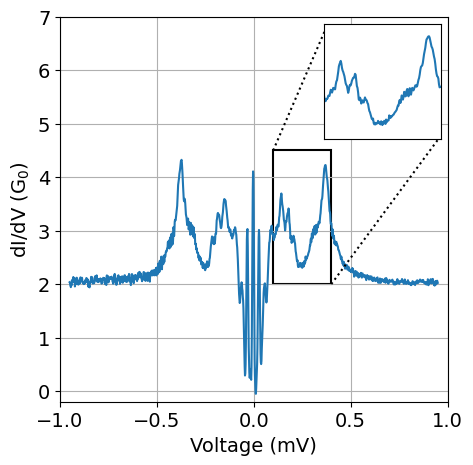

In [ ]:
x = bib.evaluation.cached_sets["adwin"].curves["voltage-bin"]
y = bib.evaluation.cached_sets["diffs"].curves["diff_conductance"]

x = x[5:-5]
y = y[5:-5]

x = x[:-5]
y = Math.moving_average(y, 6)

x = x * 1e3

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x, y)

# inset
ax.add_patch(
    mpatches.Rectangle((0.1, 2), 0.3, 2.5, fill=False, color="black", linewidth=1.5)
)
ax.plot(
    [0.1, 0.38],
    [4.5, 6.85],
    color="black",
    linewidth=1.5,
    linestyle=":",
)
ax.plot(
    [0.4, 0.95],
    [2, 4.7],
    color="black",
    linewidth=1.5,
    linestyle=":",
)


ax.set_xlabel("Voltage (mV)", fontsize=14)
ax.set_ylabel("dI/dV (G$_0$)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.2, 7)
ax.grid()

# =================================================

ax_inset = inset_axes(
    ax,
    width="30%",
    height="30%",
    loc="upper right",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=ax.transAxes,
)
ax_inset.plot(x, y)
ax_inset.set_xlim(0.1, 0.4)
ax_inset.set_ylim(2, 4.5)
ax_inset.tick_params(labelleft=False, labelbottom=False)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\capal\AppData\Local\Temp\ipykernel_10332\3221653249.py:15: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel("eV$_0$ ($\Delta$)", fontsize=14)


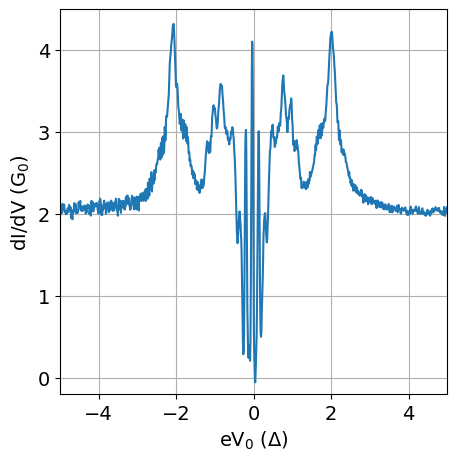

In [ ]:
x = bib.evaluation.persistent_sets["norm"].curves["voltage-bin"]
y = bib.evaluation.cached_sets["diffs"].curves["diff_conductance"]

x = x[5:-5]
y = y[5:-5]

x = x[:-5]
y = Math.moving_average(y, 6)


fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(x, y)

ax.set_xlabel("eV$_0$ ($\Delta$)", fontsize=14)
ax.set_ylabel("dI/dV (G$_0$)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)
ax.set_xlim(-5, 5)
ax.set_ylim(-0.2, 4.5)
ax.grid()

(Test) GenEval.select_CurveSet(var_range_index=25)
(Test)   Selected DataSet: nu=-6.0dBm
(Test) IVEval.loadCurveSet()
(Test)   Loading dataset: nu=-6.0dBm from var=(vna_amplitudes,(-3.1e+01,0e+00),Bm) const=[(vna_frequency,1.5e+10,Hz)]
(Test) IVEval.filter_curve_sets(bin_count=1200)
(Test) IVEval.eval_loaded_curve_set()
(Test) IVEval.get_noise(adwin, ('time', 'current'), It)


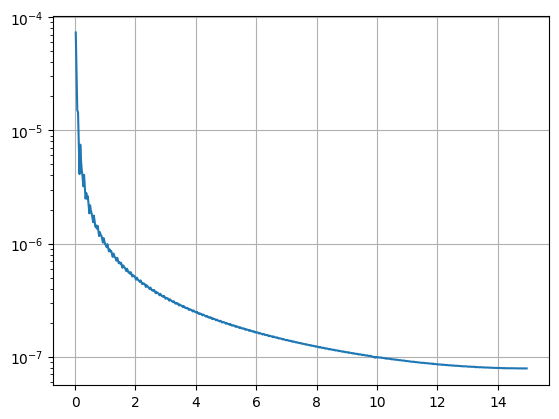

In [ ]:
plt.figure()

Macros.load(bib, 25)
Macros.eval(bib, "adwin")

t = bib.evaluation.cached_sets["adwin"].curves["time-bin"]
c = bib.evaluation.cached_sets["adwin"].curves["current"]

n = len(t)
dx = float(np.median(np.diff(t)))
freqs = np.fft.fftfreq(n, dx)[: n // 2]
spec = np.abs(np.fft.fft(c)[: n // 2])

plt.plot(freqs[1:], spec[1:])
plt.yscale("log")
plt.grid()